# **Кошкарев 20223**

# <center> Лабораторная работа 1.  </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### Необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. 

###История транзакция находится на сайте [Kaggle](https://www.kaggle.com/c/python-and-analyze-data-final-project/data)

### Вы будете строить предиктивные модели и отправлять результаты своего моделирования на платформу [Kaggle](https://www.kaggle.com/t/e8a939488d274dab9051cce14d5ca952), где и будет оцениваться каждое решение и положение участников. 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

гистограмма пол - магазин автоматизировать

магазин удалить - сделать 50 колонок и фигачить туда сумму

если не покупал в магазе - 0

цикл по всем атрибутам и проверить гипотеза об однородности?

# kaggle
https://www.kaggle.com/c/python-and-analyze-data-final-project/submit

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from tqdm._tqdm_notebook import tqdm_notebook

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [ ]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

In [ ]:
def printt(data):
  pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  print(data)
  pd.set_option('display.max_rows', 20)
  pd.set_option('display.max_columns', 20)

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим наборы данных

* transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.
* gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.
* tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.
* tr_types.csv - таблица содержит описание типов транзакций.
*gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения.

5631;Аксессуары для женщин

In [ ]:
dir = '/content/drive/MyDrive/nmo/01/'
tr_mcc_codes = pd.read_csv(dir+'tr_mcc_codes.csv', sep=';',index_col='mcc_code')
tr_types = pd.read_csv(dir+'tr_types.csv', sep=';', index_col='tr_type')
gender_train = pd.read_csv(dir+'gender_train.csv',index_col='customer_id')
gender_test = pd.read_csv(dir+'gender_test_kaggle_sample_submission.csv',index_col='customer_id')
transactions = pd.read_csv(dir+'transactions.csv',index_col='customer_id')
# transactions = pd.read_csv(dir+'transactions.zip',index_col='customer_id')


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
transactions['log_amount'] = np.sign(transactions['amount'])*np.log10(np.abs(transactions['amount'])) 
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner') 

In [ ]:
gender_train

,gender
customer_id,
10928546,1
69348468,1
61009479,0
74045822,0
27979606,1
...,...
90417572,0
66837341,0
10758984,1


In [ ]:
# transactions_train.isna().sum()

Так как суммы расходов могут быть очень большими, то выполним преобразование - прологарифмируем суммы расходов и доходов, сохраняя знак

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tr_mcc_codes)
#transactions_train = transactions_train.loc[transactions_train['mcc_code']==5977]

                                            mcc_description
mcc_code                                                   
742                                     Ветеринарные услуги
1711      Генеральные подрядчики по вентиляции, теплосна...
1731                            Подрядчики по электричеству
1799      Подрядчики, специализированная торговля — нигд...
2741               Разнообразные издательства/печатное дело
3000                                Авиалинии, авиакомпании
3351                        Агентства по аренде автомобилей
3501                         Жилье — отели, мотели, курорты
4111      Транспортировка — пригородные и локальные сезо...
4112                        Пассажирские железные перевозки
4121                                       Лимузины и такси
4131                                       Автобусные линии
4214      Агентства по автотранспортным перевозкам, мест...
4215      Услуги курьера — по воздуху и на земле, агентс...
4411                                    

In [ ]:
tr_types

,tr_description
tr_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...
...,...
2990,Списание по требованию
2992,Списание средств для погашения задолженности п...
3001,Комиссия за обслуживание ссудного счета


Сформируем базовые переменные по каждому клиенту. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:

* минимум
* максимум
* среднее
* медиана
* среднеквадратичное отклонение
* количество


!!!!!!!!!!!!!!!!!!!!!


In [ ]:
# def features_creation_basic(x): 
#     base_feature = 'log_amount'
#     features = []
#     features.append(pd.Series(x[x[base_feature]>0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
#                                                         .add_prefix('positive_transactions_')))
#     features.append(pd.Series(x[x[base_feature]<0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
#                                                         .add_prefix('negative_transactions_')))
    

#     # term_id_mask = transactions_train['term_id'].value_counts()
#     # transactions_train['term_id'] = np.where(transactions_train['term_id'].isin(term_id_mask.index[term_id_mask < 2]), transactions_train['term_id'], -1)

#     # features.append(pd.Series(x[x['mcc_code']][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
#     #                                                     .add_prefix('positive_transactions_')))
 
#     return pd.concat(features)



In [ ]:
import re
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = (~df['hour'].between(6, 22)).astype(int)

In [ ]:
transactions_train['night'].unique()

array([0, 1])

In [ ]:
def features_creation_basic2(x): 
    features = []
    base_feature = 'log_amount'
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x[base_feature]>0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x[base_feature]<0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    result = x.groupby('mcc_code')['log_amount'].mean().fillna(0)
    result.index = result.index.map(lambda e: 'mcc_code_mean' + str(e))
    features.append(result)
 
    return pd.concat(features)

In [ ]:
tqdm_notebook.pandas(desc="Progress:")
data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic2).unstack()
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic2).unstack()

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [ ]:
data_train['mcc_code_mean4511']

customer_id
22899            NaN
28753      -5.615881
42096            NaN
49793            NaN
50940            NaN
              ...   
99917144         NaN
99967537         NaN
99984336         NaN
99988578         NaN
99999680         NaN
Name: mcc_code_mean4511, Length: 8400, dtype: float64

In [ ]:
data_train

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_min,negative_transactions_std,night_0,night_1,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,0.132479,0.141026,0.089744,0.136752,0.179487,0.170940,0.149573,0.008547,0.025641,0.059829,...,-5.938824,0.746413,0.914530,0.085470,68.0,5.942458,4.457634,4.527485,1.944680,0.743689
28753,0.221088,0.051020,0.061224,0.214286,0.163265,0.149660,0.139456,0.227891,0.003401,0.091837,...,-6.511153,0.916209,0.591837,0.408163,50.0,6.491273,5.708695,5.845334,3.895462,0.565669
42096,0.117521,0.158120,0.188034,0.175214,0.141026,0.125000,0.095085,0.134615,NaN,0.061966,...,-5.528641,0.587829,0.826923,0.173077,66.0,5.828515,5.064168,5.050363,3.828515,0.391880
49793,0.177388,0.099415,0.103314,0.157895,0.138402,0.189084,0.134503,0.068226,NaN,0.040936,...,-5.828515,0.716546,0.922027,0.077973,25.0,5.050363,4.040181,4.050364,3.050364,0.592910
50940,0.161017,0.101695,0.093220,0.186441,0.144068,0.135593,0.177966,NaN,NaN,0.067797,...,-5.041590,0.485151,0.966102,0.033898,12.0,3.652423,3.652423,3.652423,3.652423,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,0.095522,0.129851,0.119403,0.171642,0.155224,0.164179,0.164179,0.098507,NaN,0.016418,...,-5.722461,0.640782,0.729851,0.270149,7.0,4.351394,3.950511,4.050364,3.351394,0.360842
99967537,0.076923,NaN,NaN,0.307692,0.230769,0.153846,0.230769,NaN,NaN,NaN,...,-5.527485,0.954335,1.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
99984336,0.111111,0.126984,0.015873,0.095238,0.285714,0.190476,0.174603,0.047619,NaN,NaN,...,-5.782757,0.586380,0.936508,0.063492,18.0,5.905276,4.881654,4.828515,4.652424,0.305477


In [ ]:
transactions_train

,tr_datetime,mcc_code,tr_type,amount,term_id,log_amount,gender,day,hour,night
customer_id,,,,,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,-3.652423,1,1,15,0
22899,2 20:52:48,4814,1030,-2245.92,NaN,-3.351394,1,2,20,0
22899,5 18:52:19,6011,2010,-44918.32,NaN,-4.652424,1,5,18,0
22899,6 12:28:22,6011,2010,-150476.36,NaN,-5.177468,1,6,12,0
22899,28 10:41:01,6010,7030,33688.74,NaN,4.527485,1,0,10,0
...,...,...,...,...,...,...,...,...,...,...
99999680,444 00:00:00,5411,1110,-5659.71,31190432,-3.752794,1,3,0,1
99999680,444 00:00:00,6011,2110,-134754.95,406826,-5.129545,1,3,0,1
99999680,446 00:00:00,5541,1110,-11229.58,J038003,-4.050364,1,5,0,1


transactions_train['mcc_code'].value_counts()
сорт батвы и добавить в колонку топ N. в нее писать 1 или 0 (или колво) в таблу min max ...

In [ ]:
transactions_train['mcc_code'].value_counts()

6011    813382
4814    548437
5411    539410
6010    504550
4829    331357
         ...  
7829        32
8244        29
5697        24
2741        22
6513        15
Name: mcc_code, Length: 184, dtype: int64

In [ ]:
transactions_train

,tr_datetime,mcc_code,tr_type,amount,term_id,log_amount,gender,day,hour,night
customer_id,,,,,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,-3.652423,1,1,15,0
22899,2 20:52:48,4814,1030,-2245.92,NaN,-3.351394,1,2,20,0
22899,5 18:52:19,6011,2010,-44918.32,NaN,-4.652424,1,5,18,0
22899,6 12:28:22,6011,2010,-150476.36,NaN,-5.177468,1,6,12,0
22899,28 10:41:01,6010,7030,33688.74,NaN,4.527485,1,0,10,0
...,...,...,...,...,...,...,...,...,...,...
99999680,444 00:00:00,5411,1110,-5659.71,31190432,-3.752794,1,3,0,1
99999680,444 00:00:00,6011,2110,-134754.95,406826,-5.129545,1,3,0,1
99999680,446 00:00:00,5541,1110,-11229.58,J038003,-4.050364,1,5,0,1


In [ ]:
data_train

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_min,negative_transactions_std,night_0,night_1,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,0.132479,0.141026,0.089744,0.136752,0.179487,0.170940,0.149573,0.008547,0.025641,0.059829,...,-5.938824,0.746413,0.914530,0.085470,68.0,5.942458,4.457634,4.527485,1.944680,0.743689
28753,0.221088,0.051020,0.061224,0.214286,0.163265,0.149660,0.139456,0.227891,0.003401,0.091837,...,-6.511153,0.916209,0.591837,0.408163,50.0,6.491273,5.708695,5.845334,3.895462,0.565669
42096,0.117521,0.158120,0.188034,0.175214,0.141026,0.125000,0.095085,0.134615,NaN,0.061966,...,-5.528641,0.587829,0.826923,0.173077,66.0,5.828515,5.064168,5.050363,3.828515,0.391880
49793,0.177388,0.099415,0.103314,0.157895,0.138402,0.189084,0.134503,0.068226,NaN,0.040936,...,-5.828515,0.716546,0.922027,0.077973,25.0,5.050363,4.040181,4.050364,3.050364,0.592910
50940,0.161017,0.101695,0.093220,0.186441,0.144068,0.135593,0.177966,NaN,NaN,0.067797,...,-5.041590,0.485151,0.966102,0.033898,12.0,3.652423,3.652423,3.652423,3.652423,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,0.095522,0.129851,0.119403,0.171642,0.155224,0.164179,0.164179,0.098507,NaN,0.016418,...,-5.722461,0.640782,0.729851,0.270149,7.0,4.351394,3.950511,4.050364,3.351394,0.360842
99967537,0.076923,NaN,NaN,0.307692,0.230769,0.153846,0.230769,NaN,NaN,NaN,...,-5.527485,0.954335,1.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
99984336,0.111111,0.126984,0.015873,0.095238,0.285714,0.190476,0.174603,0.047619,NaN,NaN,...,-5.782757,0.586380,0.936508,0.063492,18.0,5.905276,4.881654,4.828515,4.652424,0.305477


In [ ]:
data_train

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_min,negative_transactions_std,night_0,night_1,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,0.132479,0.141026,0.089744,0.136752,0.179487,0.170940,0.149573,0.008547,0.025641,0.059829,...,-5.938824,0.746413,0.914530,0.085470,68.0,5.942458,4.457634,4.527485,1.944680,0.743689
28753,0.221088,0.051020,0.061224,0.214286,0.163265,0.149660,0.139456,0.227891,0.003401,0.091837,...,-6.511153,0.916209,0.591837,0.408163,50.0,6.491273,5.708695,5.845334,3.895462,0.565669
42096,0.117521,0.158120,0.188034,0.175214,0.141026,0.125000,0.095085,0.134615,NaN,0.061966,...,-5.528641,0.587829,0.826923,0.173077,66.0,5.828515,5.064168,5.050363,3.828515,0.391880
49793,0.177388,0.099415,0.103314,0.157895,0.138402,0.189084,0.134503,0.068226,NaN,0.040936,...,-5.828515,0.716546,0.922027,0.077973,25.0,5.050363,4.040181,4.050364,3.050364,0.592910
50940,0.161017,0.101695,0.093220,0.186441,0.144068,0.135593,0.177966,NaN,NaN,0.067797,...,-5.041590,0.485151,0.966102,0.033898,12.0,3.652423,3.652423,3.652423,3.652423,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,0.095522,0.129851,0.119403,0.171642,0.155224,0.164179,0.164179,0.098507,NaN,0.016418,...,-5.722461,0.640782,0.729851,0.270149,7.0,4.351394,3.950511,4.050364,3.351394,0.360842
99967537,0.076923,NaN,NaN,0.307692,0.230769,0.153846,0.230769,NaN,NaN,NaN,...,-5.527485,0.954335,1.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
99984336,0.111111,0.126984,0.015873,0.095238,0.285714,0.190476,0.174603,0.047619,NaN,NaN,...,-5.782757,0.586380,0.936508,0.063492,18.0,5.905276,4.881654,4.828515,4.652424,0.305477


In [ ]:
# all_features = ['positive_transactions_min',
#                 'positive_transactions_max',
#                 'positive_transactions_mean',
#                 'positive_transactions_median',
#                 'positive_transactions_std',
#                 'positive_transactions_count',
#                 'negative_transactions_min',
#                 'negative_transactions_max',
#                 'negative_transactions_mean',
#                 'negative_transactions_median',
#                 'negative_transactions_std']

all_features = list(data_train.columns)

In [ ]:
data_train

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_min,negative_transactions_std,night_0,night_1,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,0.132479,0.141026,0.089744,0.136752,0.179487,0.170940,0.149573,0.008547,0.025641,0.059829,...,-5.938824,0.746413,0.914530,0.085470,68.0,5.942458,4.457634,4.527485,1.944680,0.743689
28753,0.221088,0.051020,0.061224,0.214286,0.163265,0.149660,0.139456,0.227891,0.003401,0.091837,...,-6.511153,0.916209,0.591837,0.408163,50.0,6.491273,5.708695,5.845334,3.895462,0.565669
42096,0.117521,0.158120,0.188034,0.175214,0.141026,0.125000,0.095085,0.134615,NaN,0.061966,...,-5.528641,0.587829,0.826923,0.173077,66.0,5.828515,5.064168,5.050363,3.828515,0.391880
49793,0.177388,0.099415,0.103314,0.157895,0.138402,0.189084,0.134503,0.068226,NaN,0.040936,...,-5.828515,0.716546,0.922027,0.077973,25.0,5.050363,4.040181,4.050364,3.050364,0.592910
50940,0.161017,0.101695,0.093220,0.186441,0.144068,0.135593,0.177966,NaN,NaN,0.067797,...,-5.041590,0.485151,0.966102,0.033898,12.0,3.652423,3.652423,3.652423,3.652423,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,0.095522,0.129851,0.119403,0.171642,0.155224,0.164179,0.164179,0.098507,NaN,0.016418,...,-5.722461,0.640782,0.729851,0.270149,7.0,4.351394,3.950511,4.050364,3.351394,0.360842
99967537,0.076923,NaN,NaN,0.307692,0.230769,0.153846,0.230769,NaN,NaN,NaN,...,-5.527485,0.954335,1.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
99984336,0.111111,0.126984,0.015873,0.095238,0.285714,0.190476,0.174603,0.047619,NaN,NaN,...,-5.782757,0.586380,0.936508,0.063492,18.0,5.905276,4.881654,4.828515,4.652424,0.305477


In [ ]:
data_test

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_min,negative_transactions_std,night_0,night_1,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0.119469,0.132743,0.119469,0.163717,0.181416,0.146018,0.137168,NaN,0.004425,0.181416,...,-5.351393,0.604215,0.991150,0.008850,6.0,6.392786,4.591282,4.700878,2.351390,1.308400
27914,0.135135,0.261261,0.180180,0.090090,0.135135,0.027027,0.171171,0.018018,NaN,0.126126,...,-5.665261,0.709207,0.945946,0.054054,35.0,4.953453,3.735907,3.749334,3.050364,0.476576
31385,0.153425,0.120548,0.145205,0.123288,0.145205,0.167123,0.145205,0.030137,NaN,0.060274,...,-5.561538,0.607331,0.961644,0.038356,23.0,5.300783,4.548796,4.618565,3.351394,0.459513
38084,0.142857,0.153361,0.110294,0.130252,0.159664,0.137605,0.165966,0.143908,0.006303,0.053571,...,-6.057955,0.627298,0.825630,0.174370,114.0,6.091756,5.176949,5.183483,4.050364,0.429995
78659,0.159875,0.119122,0.134796,0.147335,0.134796,0.147335,0.156740,0.291536,NaN,0.009404,...,-4.852339,0.341888,0.636364,0.363636,46.0,5.497522,4.260941,4.351394,2.351390,0.515682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99918216,0.132979,0.175532,0.101064,0.143617,0.138298,0.117021,0.191489,0.058511,NaN,0.042553,...,-5.366334,0.568767,0.696809,0.303191,5.0,5.408298,5.085630,5.351393,4.050364,0.581575
99938948,0.148265,0.162461,0.127760,0.124606,0.145110,0.162461,0.129338,0.160883,0.001577,0.037855,...,-5.630147,0.602875,0.823344,0.176656,43.0,5.618565,4.484818,4.652424,3.351394,0.522167
99953525,0.139535,0.162791,0.162791,0.133721,0.104651,0.133721,0.162791,0.069767,NaN,0.069767,...,-5.749333,0.554365,0.813953,0.186047,16.0,5.351393,5.040898,5.050363,4.351394,0.203723


Сформируем вектор целевой переменной

In [ ]:
target = data_train.join(gender_train, how='inner')['gender']

In [ ]:
target

customer_id
22899       1
28753       0
42096       0
49793       1
50940       0
           ..
99917144    0
99967537    1
99984336    1
99988578    1
99999680    1
Name: gender, Length: 8400, dtype: int64

In [ ]:
data_train1 = data_train.join(gender_train, how='inner')

Проанализируем различные пары переменных

In [ ]:
# sns.set()
# sns.pairplot(data_train1[['positive_transactions_min',	'positive_transactions_max',	'positive_transactions_mean',	'positive_transactions_median',	'positive_transactions_std','gender']],
# hue="gender", diag_kind="kde")

In [ ]:
# sns.pairplot(data_train1[['negative_transactions_min',	'negative_transactions_max',	'negative_transactions_mean',	'negative_transactions_median',	'negative_transactions_std','gender']],
# hue="gender", diag_kind="kde")

In [ ]:
# sns.pairplot(data_train1[['positive_transactions_min', 'negative_transactions_min',	'positive_transactions_max', 'negative_transactions_max','gender']],
# hue="gender", diag_kind="kde")

In [ ]:
# sns.pairplot(data_train1[['positive_transactions_median', 'negative_transactions_median',	'positive_transactions_mean', 'negative_transactions_mean','gender']],
# hue="gender", diag_kind="kde")

Так как при агрегировании появились NAN их нужно заменить

In [ ]:
X1 = data_train
X1.isna().sum()

day_0                             46
day_1                             86
day_2                            172
day_3                             52
day_4                             40
                                ... 
positive_transactions_max        678
positive_transactions_mean       678
positive_transactions_median     678
positive_transactions_min        678
positive_transactions_std       1046
Length: 229, dtype: int64

In [ ]:
X = data_train.fillna(0)
print(len(X.isna().sum()))
X.isna().sum()



229


day_0                           0
day_1                           0
day_2                           0
day_3                           0
day_4                           0
                               ..
positive_transactions_max       0
positive_transactions_mean      0
positive_transactions_median    0
positive_transactions_min       0
positive_transactions_std       0
Length: 229, dtype: int64

In [ ]:
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

In [ ]:
import xgboost as xgb

params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [ ]:
def mcc_mean(elem): 

    result = elem.groupby('mcc_code')['log_amount'].mean()
    result.index = result.index.map(lambda e: 'mcc_code_mean' + str(e))
    # print(result)
    # print('---')
    
    return result

df = transactions_train.groupby(transactions_train.index).progress_apply(mcc_mean).unstack()
target = df.join(gender_train, how='inner')['gender']
cv_score(params, df, target)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Cross-validation, ROC AUC: 0.852+-0.005, Trees: 430


In [ ]:
target

customer_id
22899       1
28753       0
42096       0
49793       1
50940       0
           ..
99917144    0
99967537    1
99984336    1
99988578    1
99999680    1
Name: gender, Length: 8400, dtype: int64

# Важность фич

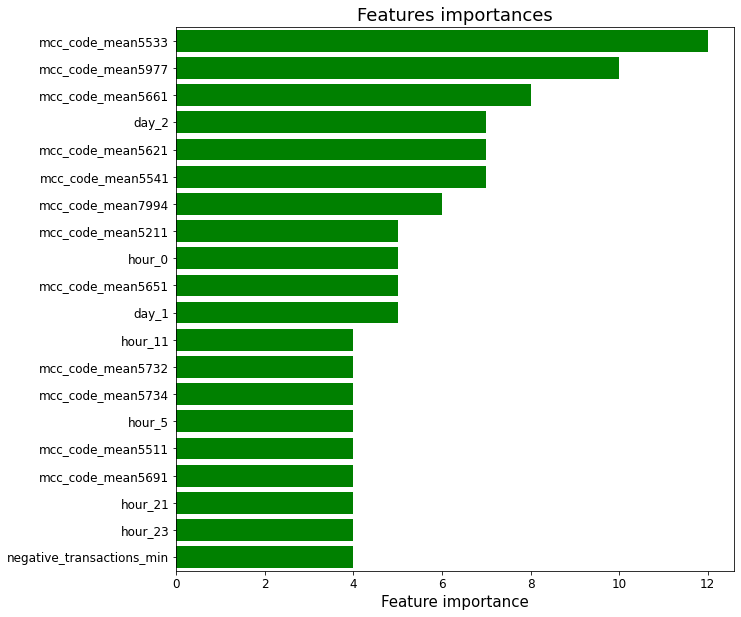

In [ ]:
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

clf, submission = fit_predict(params, 70, data_train, data_test, target)
draw_feature_importances(clf, 20)

Итого оказалось, что важными фичами являются:
*   5533;Автозапчасти и аксессуары
*   5977;Магазины косметики
*   5661;Обувные магазины
*   5621;Готовая женская одежда
*   5541;Станции техобслуживания

**И ЭТО ДЕЙСТВИТЕЛЬНО ИМЕЕТ СМЫСЛ!!!!**
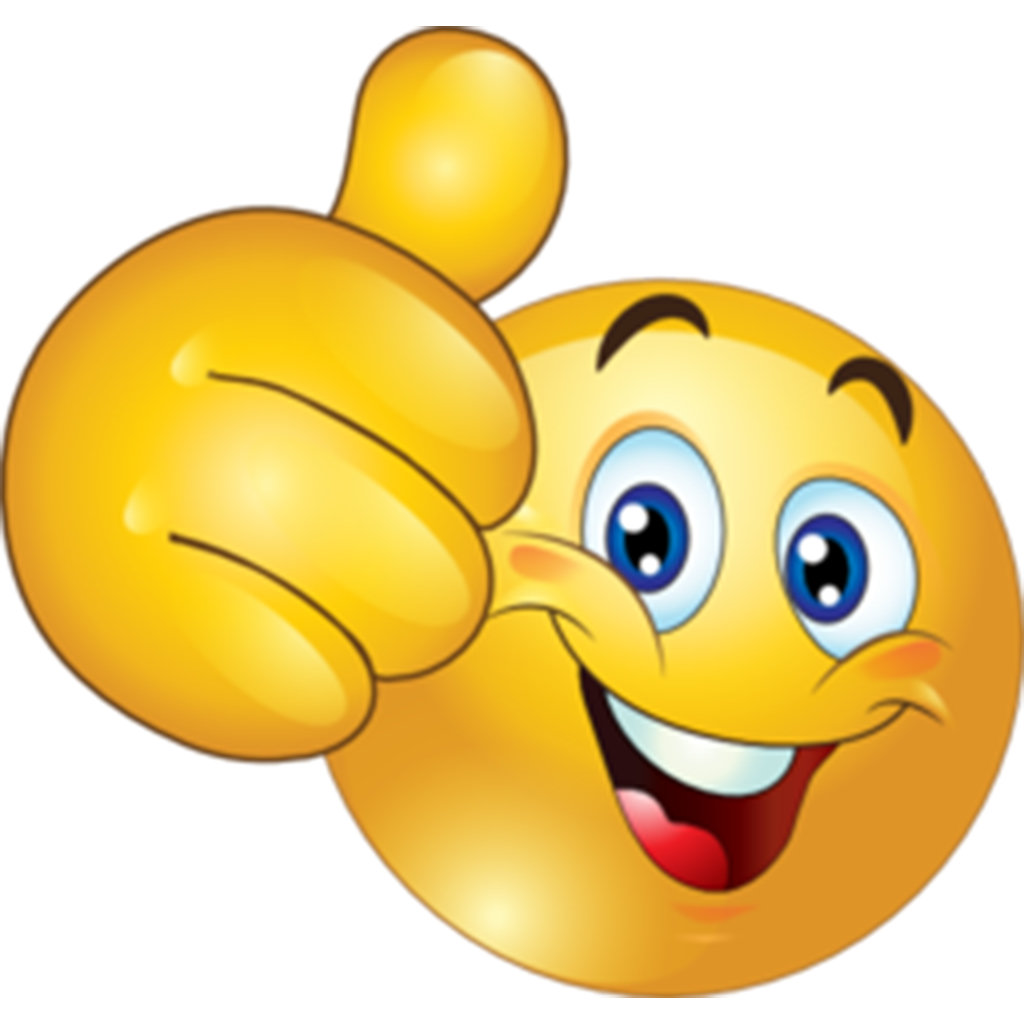

# Алгоритмы

- [x] наивный байесовский классификатор
- [x] линейный дискриминант
- [x] квадратичный дискриминант
- [x] метод опорных векторов
- [x] деревья решений (см лабы АБМД или ММО)
- [x] градиентный бустинг (RGBoost) Xgboost LightGBM Catboost !pip install catboost // import catboost // import xgboost as xgb

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3600 entries, 6815 to 99991245
Columns: 229 entries, day_0 to positive_transactions_std
dtypes: float64(229)
memory usage: 6.3 MB


In [ ]:
data_train = data_train.fillna(0)
data_test = data_test.fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train, target, train_size=0.7)

results = pd.DataFrame(columns=['name', 'roc_auc_score'])

# линейный дискриминант

In [ ]:
clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
result = clf.predict(X_test)
aa = roc_auc_score(y_test, result)
print(aa)
results.loc[len(results)] = ['линейный дискриминант', aa]

0.7568316713808128


# квадратичный дискриминант

In [ ]:
clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
result = clf.predict(X_test)

aa = roc_auc_score(y_test, result)
print(aa)
results.loc[len(results)] = ['квадратичный дискриминант', aa]

0.560295944682232


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# метод опорных векторов

In [ ]:
clf = svm.SVC(kernel='poly', degree=2).fit(X_train, y_train)
result = clf.predict(X_test)
aa = roc_auc_score(y_test, result)
print(aa)
results.loc[len(results)] = ['метод опорных векторов', aa]


0.5142893352765985


# деревья решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)
result = clf.predict(X_test)
aa = roc_auc_score(y_test, result)
print(aa)
results.loc[len(results)] = ['деревья решений', aa]

0.6315342769306397


# градиентный бустинг 

In [ ]:
clf = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.3, max_depth = 6, alpha = 0, n_estimators = 100).fit(X_train, y_train)
result = clf.predict(X_test)
aa = roc_auc_score(y_test, result)
print(aa)
results.loc[len(results)] = ['градиентный бустинг', aa]

final_model = clf

0.7998667365627634


In [ ]:
len(result)

2520

# наивный байесовский классификатор

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB().fit(X_train, y_train)
result = clf.predict_proba(X_test)[:, 1]
aa = roc_auc_score(y_test, result)
print(aa)
results.loc[len(results)] = ['наивный байесовский классификатор', aa]

0.7005800351912765


# Итоги

In [ ]:
results.sort_values(by=['roc_auc_score'], ascending=False)

,name,roc_auc_score
4,градиентный бустинг,0.799867
0,линейный дискриминант,0.756832
5,наивный байесовский классификатор,0.700580
3,деревья решений,0.631534
1,квадратичный дискриминант,0.560296
2,метод опорных векторов,0.514289



Самый эфективный метод - градиентный бустинг

In [ ]:
data_test.columns

Index(['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_0',
       'hour_1', 'hour_10',
       ...
       'negative_transactions_min', 'negative_transactions_std', 'night_0',
       'night_1', 'positive_transactions_count', 'positive_transactions_max',
       'positive_transactions_mean', 'positive_transactions_median',
       'positive_transactions_min', 'positive_transactions_std'],
      dtype='object', length=229)

In [ ]:
# clf = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.3, max_depth = 6, alpha = 0, n_estimators = 100).fit(X_train, y_train)
# result = clf.predict(X)

final_result = final_model.predict(data_test)

In [ ]:
len(final_result)

3600

In [ ]:
def download_to_kaggle(data_test, y_pred):
  submission = pd.DataFrame(index=data_test.index, data=y_pred, columns=['probability'])
  submission.to_csv('linear.csv')
  files.download('linear.csv')


In [ ]:
result

array([1.00000000e+00, 3.74028868e-07, 1.00000000e+00, ...,
       1.25094890e-81, 1.49155855e-10, 7.40751052e-11])

In [ ]:
download_to_kaggle(data_test, final_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files, output
output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

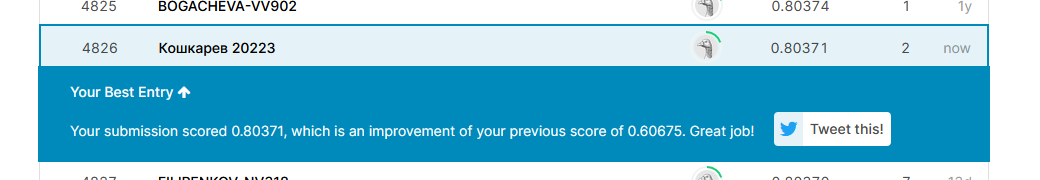

# ЧИТЫ

In [ ]:
# !pip install pycaret
# dataaaaa = data_train.join(target, how='inner')from pycaret.classification import *
# from pycaret.utils import enable_colab
# enable_colab()
# classifier_pycaret = setup(data = dataaaaa, target = 'gender', session_id=42)
# best_pycaret = compare_models()
# tuned_lr_pycaret = tune_model(lr_pycaret)
# final_lr_pycaret = finalize_model(tuned_lr_pycaret)
# predict_model(final_lr_pycaret); 